In [1]:
%matplotlib inline
import numpy as np
import os
import time
import h5py
import keras
import pandas as pd
import math
import joblib
import json
import matplotlib.pyplot as plt

from fuel.datasets.hdf5 import H5PYDataset

from scipy.stats import norm
from scipy.special import logsumexp, expit
from IPython.display import display

from keras.layers import (Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, 
                          Activation, Dropout, Conv2D, Conv2DTranspose,
                          Concatenate, Add, Multiply)
from keras.regularizers import l2
from keras.initializers import RandomUniform
from keras.optimizers import RMSprop, Adam, SGD
from keras.models import Model
from keras import metrics
from keras import backend as K
from keras_tqdm import TQDMNotebookCallback
from keras.datasets import mnist
from weightnorm import AdamWithWeightnorm, data_based_init

from resnet import identity_block, conv_block

/home/brian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Variational Autoencoder Parameters

In [2]:
img_rows, img_cols, img_chns = 32, 32, 3
original_img_size = (img_rows, img_cols, img_chns)

batch_size = int(os.environ.get('BATCH_SIZE', 25))
latent_dim = int(os.environ.get('LATENT_DIM', 512))
intermediate_dim = int(os.environ.get('INTERMEDIATE_DIM', 1024))
epsilon_std = 1.0
epochs = int(os.environ.get('EPOCHS', 100))
activation = os.environ.get('ACTIVATION', 'relu')
decay = float(os.environ.get('DECAY', 0.0))
learning_rate = float(os.environ.get('LEARNING_RATE', 0.001))
resnet_depth = int(os.environ.get('RESNET_DEPTH', 1))

## Load CIFAR10 dataset

In [3]:
ftrain = H5PYDataset("../../data/cifar10/cifar10.hdf5", which_sets=('train',))
X_train, y_train = ftrain.get_data(ftrain.open(), slice(0, ftrain.num_examples))
X_train = np.moveaxis(X_train[:], 1, 3)
X_train = X_train / 255.

ftest = H5PYDataset("../../data/cifar10/cifar10.hdf5", which_sets=('test',))
X_test, y_test = ftest.get_data(ftest.open(), slice(0, ftest.num_examples))
X_test = np.moveaxis(X_test[:], 1, 3)
X_test = X_test / 255.

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


# Helper Functions

In [4]:
def epsilon(args, batch_size=batch_size, latent_dim=latent_dim, epsilon_std=epsilon_std):
    return K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=epsilon_std)

def combine_z_0(args, batch_size=batch_size, latent_dim=latent_dim, epsilon_std=epsilon_std):
    eps, z_mean, z_log_sigma = args
    return z_mean + K.exp(z_log_sigma) * eps

def resnet_layers(x, depth, stage_base, transpose=False):
    assert depth in [0, 1, 2, 3]
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
   
    filters_seq = [[64, 64, 256], [128, 128, 512], [256, 256, 1024], [512, 512, 2048]]
    filters = filters_seq[0 if not transpose else -1]
    x = conv_block(x, 3, filters, stage=stage_base + 2, block='a', strides=(1, 1), transpose=transpose)
    if depth >= 1:
        x = identity_block(x, 3, filters, stage=stage_base + 2, block='b')
    if depth >= 2:
        x = identity_block(x, 3, filters, stage=stage_base + 2, block='c')
    if depth >= 3:
        x = identity_block(x, 3, filters, stage=stage_base + 2, block='d')
   
    filters = filters_seq[1 if not transpose else -2]
    x = conv_block(x, 3, filters, stage=stage_base + 3, block='a', transpose=transpose)
    if depth >= 1:
        x = identity_block(x, 3, filters, stage=stage_base + 3, block='b')
    if depth >= 2:
        x = identity_block(x, 3, filters, stage=stage_base + 3, block='c')
    if depth >= 3:
        x = identity_block(x, 3, filters, stage=stage_base + 3, block='d')
    
    filters = filters_seq[2 if not transpose else -3]
    x = conv_block(x, 3, filters, stage=stage_base + 4, block='a', transpose=transpose)
    if depth >= 1:
        x = identity_block(x, 3, filters, stage=stage_base + 4, block='b')
    if depth >= 2:
        x = identity_block(x, 3, filters, stage=stage_base + 4, block='c')
    if depth >= 3:
        x = identity_block(x, 3, filters, stage=stage_base + 4, block='d')
   
    filters = filters_seq[3 if not transpose else -4]
    x = conv_block(x, 3, filters, stage=stage_base + 5, block='a', transpose=transpose)
    if depth >= 1:
        x = identity_block(x, 3, filters, stage=stage_base + 5, block='b')
    if depth >= 2:
        x = identity_block(x, 3, filters, stage=stage_base + 5, block='c')
    if depth >= 3:
        x = identity_block(x, 3, filters, stage=stage_base + 5, block='d')
    
    return x

## Loss Function

In [5]:
def logpz(x, decoder_out):
    return -K.sum(0.5 * np.log(2*math.pi) + 0.5 * z ** 2, axis=-1)

def logqz_x(x, decoder_out):
    return -K.sum(0.5 * np.log(2*math.pi) + 0.5 * e_0 ** 2 + z_log_sigma, axis=-1)

def logpx_z(x, decoder_out):
    # Model sub-pixels as a (single) continuous logistic distribution
    # Assume sample is drawn from this intensity distribution and rounded
    # Same as Kingma, PixelCNN++ paper
    # https://github.com/openai/pixel-cnn
    x = K.batch_flatten(x)
    x_decoded_m = K.batch_flatten(g_output_m)
    x_decoded_invs = K.batch_flatten(g_output_invs)
   
    offset = 1. / 255. / 2.
    centered_mean = x - x_decoded_m
    cdfminus_arg = (centered_mean - offset) * K.exp(x_decoded_invs)
    cdfplus_arg = (centered_mean + offset) * K.exp(x_decoded_invs)
                   
    cdfminus_safe = K.sigmoid(cdfminus_arg)
    cdfplus_safe = K.sigmoid(cdfplus_arg)
  
    # ln (sigmoid(x)) = x - ln(e^x + 1) = x - softplus(x)
    log_cdfplus = cdfplus_arg - K.tf.nn.softplus(cdfplus_arg)
    log_1minus_cdf = -K.tf.nn.softplus(cdfminus_arg)
    result = K.tf.where(x <= 0.001, log_cdfplus,
                        K.tf.where(x >= 0.999, log_1minus_cdf,
                                   K.log(K.maximum(cdfplus_safe - cdfminus_safe, 1e-10))))
   
    return K.sum(result, axis=-1)

def vae_loss(x, decoder_out):
    # ELBO: - [logp(x|z) + logp(z) - logq(z|x)] = -logp(x|z) - logp(z) + logq(z|x)
    return K.mean(-logpx_z(x, decoder_out) - logpz(x, decoder_out) + logqz_x(x, decoder_out), axis=-1)

# VAE

In [6]:
def make_encoder():
    encoder_input = Input(original_img_size)
    resnet = resnet_layers(encoder_input, depth=resnet_depth, stage_base=0)
    
    x = Dense(intermediate_dim)(resnet)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Flatten()(x)
    z_mean = Dense(latent_dim)(x)
    
    x = Dense(intermediate_dim)(resnet)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Flatten()(x)
    
    # Constrain sigma so it doesn't blow up
    x = Dense(latent_dim, activation='tanh')(x)
    z_log_sigma = Lambda(lambda x: 5.0 * x, output_shape=(latent_dim,))(x)
    
    return Model(inputs=encoder_input, outputs=[z_mean, z_log_sigma])

def make_decoder():
    decoder_input = Input((latent_dim,))
    
    x = Dense(intermediate_dim)(decoder_input)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Reshape((4, 4, intermediate_dim // 16))(x)

    dec_out = resnet_layers(x, depth=resnet_depth, transpose=True, stage_base=10)
    
    decoder_out_m = Conv2D(name='x_m', filters=3, kernel_size=1, strides=1, activation='sigmoid')(dec_out)
    decoder_out_invs_ = Conv2D(name='x_s', filters=3, kernel_size=1, strides=1, activation='sigmoid')(dec_out)
    decoder_out_invs = Lambda(lambda x: 7. * x)(decoder_out_invs_)
 
    return Model(inputs=decoder_input, outputs=[decoder_out_m, decoder_out_invs])

In [7]:
encoder = make_encoder()
decoder = make_decoder()

encoder.summary()
decoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
res2a_branch2a (Conv2D)         (None, 32, 32, 64)   256         input_1[0][0]                    
__________________________________________________________________________________________________
bn2a_branch2a (BatchNormalizati (None, 32, 32, 64)   256         res2a_branch2a[0][0]             
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 64)   0           bn2a_branch2a[0][0]              
__________________________________________________________________________________________________
res2a_bran

In [8]:
# VAE
g_input = Input(shape=original_img_size)
z_mean, z_log_sigma = encoder(g_input)
e_0 = Lambda(epsilon)(z_mean)
z = Lambda(combine_z_0, output_shape=(latent_dim,))([e_0, z_mean, z_log_sigma])
g_output_m, g_output_invs = decoder(z)

vae = Model(inputs=g_input, outputs=g_output_m)
optimizer = Adam(lr=learning_rate, decay=decay)
vae.compile(optimizer=optimizer, loss=vae_loss, metrics=[logpz, logqz_x, logpx_z])
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 [(None, 512), (None, 34945984    input_3[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (25, 512)            0           model_1[1][0]                    
__________________________________________________________________________________________________
lambda_4 (Lambda)               (25, 512)            0           lambda_3[0][0]                   
                                                                 model_1[1][0]                    
          

In [9]:
start = time.time()

early_stopping = keras.callbacks.EarlyStopping('logpx_z', min_delta=10., patience=20)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='logpx_z', factor=0.1, patience=10, min_lr=0.001 * learning_rate)
callbacks = [early_stopping, reduce_lr]
if 'CMDLINE' not in os.environ:
    callbacks += [TQDMNotebookCallback()]

history = vae.fit(
    # FIX ME:
    X_train, X_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_test, X_test),
    verbose=0
)

done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)


Elapsed:  7867.4602999687195


,val_loss,val_logpz,val_logqz_x,val_logpx_z,loss,logpz,logqz_x,logpx_z,lr
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,15255.706038,-493.886342,1833.489879,-12928.329823,15356.423428,-496.778185,1833.352151,-13026.293089,0.000571
std,1040.562265,46.899270,0.169397,1018.884843,801.960709,71.745180,0.582752,748.777922,0.000461
min,14352.647412,-689.246731,1833.175599,-15697.445947,14692.042373,-808.941088,1830.837184,-15278.933176,0.000100
0%,14352.647412,-689.246731,1833.175599,-15697.445947,14692.042373,-808.941088,1830.837184,-15278.933176,0.000100
25%,14412.320176,-484.759757,1833.368643,-13555.062124,14751.062911,-486.484112,1833.411446,-13355.954543,0.000100
50%,14915.450862,-477.695212,1833.489364,-12603.025479,15245.389370,-478.145327,1833.481654,-12916.889306,0.001000
75%,15873.989915,-476.533386,1833.554542,-12102.511533,15672.153889,-476.781687,1833.550171,-12440.713658,0.001000
95%,16733.395657,-476.088822,1833.729636,-12050.449744,16486.768576,-476.356544,1833.584828,-12386.829788,0.001000
99%,17778.015534,-475.777568,1833.811584,-12044.292917,17632.322892,-476.247039,1833.620464,-12383.120615,0.001000


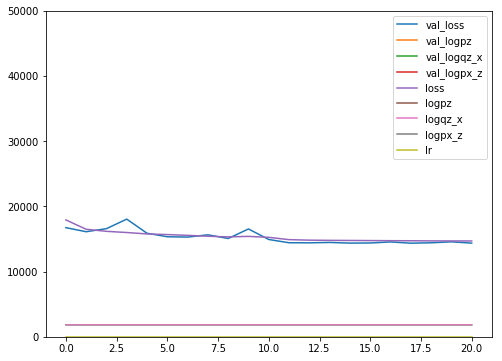

In [10]:
df = pd.DataFrame(history.history)
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
df.plot(figsize=(8, 6), ylim=(0, 50000))

In [11]:
# Eval logpz loss
temp_model = Model(inputs=g_input, outputs=g_output_m)
temp_model.compile(optimizer=optimizer, loss=logpz)
eval_result = temp_model.evaluate(x=X_test, y=X_test, batch_size=batch_size)
print("logpx = %.2f" % eval_result)

# Eval logqz_x loss
temp_model = Model(inputs=g_input, outputs=g_output_m)
temp_model.compile(optimizer=optimizer, loss=logqz_x)
eval_result = temp_model.evaluate(x=X_test, y=X_test, batch_size=batch_size)
print("logqz_x = %.2f" % eval_result)

# Eval logqz_x loss
temp_model = Model(inputs=g_input, outputs=g_output_m)
temp_model.compile(optimizer=optimizer, loss=logpx_z)
eval_result = temp_model.evaluate(x=X_test, y=X_test, batch_size=batch_size)
print("logpx_z = %.2f" % eval_result)

# Eval logpx loss
eval_result = vae.evaluate(x=X_test, y=X_test, batch_size=batch_size)
print("Metrics = %s" % eval_result)

10000/10000 [==============================] - 11s 1ms/step
logpx = -476.09
10000/10000 [==============================] - 11s 1ms/step
logqz_x = 1833.67
10000/10000 [==============================] - 20s 2ms/step
logpx_z = -12050.46
10000/10000 [==============================] - 18s 2ms/step
Metrics = [14359.910673828124, -476.08877532958985, 1833.5438323974608, -12050.278120117187]


In [12]:
def compute_samples(data, num_samples, debug=False):
    """ Sample from importance distribution z_samples ~ q(z|X) and
        compute p(z_samples), q(z_samples) for importance sampling
    """
    z_mean, z_log_sigma = encoder.predict(data)
    z_samples = []
    qz = []
    
    for m, s in zip(z_mean, z_log_sigma):
        z_vals = [np.random.normal(m[i], np.exp(s[i]), num_samples)
                  for i in range(len(m))]
        qz_vals = [norm.pdf(z_vals[i], loc=m[i], scale=np.exp(s[i]))
                   for i in range(len(m))]
        z_samples.append(z_vals)
        qz.append(qz_vals)
    
    z_samples = np.array(z_samples)
    pz = norm.pdf(z_samples)
    qz = np.array(qz)
    
    z_samples = np.swapaxes(z_samples, 1, 2)
    pz = np.swapaxes(pz, 1, 2)
    qz = np.swapaxes(qz, 1, 2)
   
    if debug:
        print(z_mean.shape, z_log_sigma.shape)
        print('m, s', m[0], s[0])
        print('samples', z_samples[-1][0])
        print('pvals', pz[-1][0])
        print('qvals', qz[-1][0])
        
        print(z_samples.shape)
        print(pz.shape)
        print(qz.shape)
    
    return z_samples, pz, qz
    
#compute_samples(X_test[17:18], 4, debug=True);

In [13]:
def estimate_logpx_batch(data, num_samples, debug=False):
    z_samples, pz, qz = compute_samples(data, num_samples)
    assert len(z_samples) == len(data)
    assert len(z_samples) == len(pz)
    assert len(z_samples) == len(qz)
    
    # Calculate importance sample
    # \log p(x) = E_p[p(x|z)]
    # = \log(\int p(x|z) p(z) dz)
    # = \log(\int p(x|z) p(z) / q(z|x) q(z|x) dz)
    # = E_q[p(x|z) p(z) / q(z|x)]
    # ~= \log(1/n * \sum_i p(x|z_i) p(z_i)/q(z_i))
    # = \log p(x) = \log(1/n * \sum_i e^{\log p(x|z_i) + \log p(z_i) - \log q(z_i)})
    # = \log p(x) = -\logn + \logsumexp_i(\log p(x|z_i) + \log p(z_i) - \log q(z_i))
    # See: scipy.special.logsumexp
    result = []
    for i in range(len(data)):
        datum = data[i].reshape(img_rows * img_cols * img_chns)
        x_predict_m, x_predict_s = decoder.predict(z_samples[i])
        x_predict_m = x_predict_m.reshape(-1, img_rows * img_cols * img_chns)
        x_predict_s = x_predict_s.reshape(-1, img_rows * img_cols * img_chns)
        p_vals = np.clip(pz[i], np.finfo(float).eps, None)
        q_vals = np.clip(qz[i], np.finfo(float).eps, None)

        # Each sub-pixel is a logistic distribution, see explanation above in vae_loss
        cdfminus_arg = np.clip((datum - x_predict_m - 1. / 255. / 2.) * np.exp(x_predict_s), -11, 10)
        cdfplus_arg = np.clip((datum - x_predict_m + 1. / 255. / 2.) * np.exp(x_predict_s), -10, 11)
        cdfminus = np.where(datum >= 0.001, expit(cdfminus_arg), np.zeros(cdfminus_arg.shape))
        cdfplus = np.where(datum <= 0.999, expit(cdfplus_arg), np.ones(cdfplus_arg.shape))
        logp_xz = np.sum(np.log(cdfplus - cdfminus), axis=-1)
        logpz = np.sum(np.log(p_vals), axis=-1)
        logqz = np.sum(np.log(q_vals), axis=-1)
        
        argsum = logp_xz + logpz - logqz
        logpx = -np.log(num_samples) + logsumexp(argsum)
        result.append(logpx)
        
        if debug:
            print(x_predict.shape)
            print(p_vals.shape)
            print(q_vals.shape)
            print(logp_xz.shape)
            print(logpz.shape)
            print(logqz.shape)
            print(x_predict.shape)
            print(datum.shape)
            print("1 - x_predict", 1. - x_predict)
            print("np.log (1. - x_predict)", np.sum(np.log(x_predictm1), axis=-1))
            print("logp_xz", logp_xz)
            print("logpz", logpz)
            print("logqz", logqz)
            print(argsum.shape)
            print("logpx", logpx)
            
    return np.array(result)
            
#estimate_logpx_batch(X_test[:2], num_samples=128, debug=True)
#pass

In [14]:
def estimate_logpx(data, num_samples, verbosity=0):
    batches = []
    iterations = int(np.ceil(1. * len(data) / batch_size))
    for b in range(iterations):
        batch_data = data[b * batch_size:(b+1) * batch_size]
        batches.append(estimate_logpx_batch(batch_data, num_samples))
        if verbosity and b % max(11 - verbosity, 1) == 0:
            print("Batch %d [%d, %d): %.2f" % (b, b*batch_size, (b+1) * batch_size, 
                                               np.mean(np.concatenate(batches))))
            np.mean(np.concatenate(batches))        
    return np.mean(np.concatenate(batches))
    
logpx = estimate_logpx(X_test, num_samples=128, verbosity=10)
print("log p(x) = %.2f" % logpx)
print("log2 p(x) = %.2f" % (logpx / np.log(2)))
print("bits/dim = log2 p(x) / 3072 = %.2f" % (-logpx / np.log(2) / img_rows / img_cols/ img_chns))

Batch 0 [0, 25): -14701.30
Batch 1 [25, 50): -14670.28
Batch 2 [50, 75): -14515.45
Batch 3 [75, 100): -14353.06
Batch 4 [100, 125): -14304.08
Batch 5 [125, 150): -14368.52
Batch 6 [150, 175): -14337.19
Batch 7 [175, 200): -14328.59
Batch 8 [200, 225): -14315.23
Batch 9 [225, 250): -14291.97
Batch 10 [250, 275): -14289.57
Batch 11 [275, 300): -14312.91
Batch 12 [300, 325): -14284.90
Batch 13 [325, 350): -14313.14
Batch 14 [350, 375): -14329.72
Batch 15 [375, 400): -14326.25
Batch 16 [400, 425): -14320.03
Batch 17 [425, 450): -14315.45
Batch 18 [450, 475): -14329.00
Batch 19 [475, 500): -14304.11
Batch 20 [500, 525): -14305.53
Batch 21 [525, 550): -14312.66
Batch 22 [550, 575): -14300.76
Batch 23 [575, 600): -14308.11
Batch 24 [600, 625): -14310.75
Batch 25 [625, 650): -14305.11
Batch 26 [650, 675): -14313.74
Batch 27 [675, 700): -14310.51
Batch 28 [700, 725): -14296.94
Batch 29 [725, 750): -14306.38
Batch 30 [750, 775): -14294.47
Batch 31 [775, 800): -14298.20
Batch 32 [800, 825): -1430

Batch 247 [6175, 6200): -14310.27
Batch 248 [6200, 6225): -14309.63
Batch 249 [6225, 6250): -14309.15
Batch 250 [6250, 6275): -14308.80
Batch 251 [6275, 6300): -14309.46
Batch 252 [6300, 6325): -14310.61
Batch 253 [6325, 6350): -14310.37
Batch 254 [6350, 6375): -14309.91
Batch 255 [6375, 6400): -14310.25
Batch 256 [6400, 6425): -14309.50
Batch 257 [6425, 6450): -14309.10
Batch 258 [6450, 6475): -14308.17
Batch 259 [6475, 6500): -14308.55
Batch 260 [6500, 6525): -14306.95
Batch 261 [6525, 6550): -14306.03
Batch 262 [6550, 6575): -14305.57
Batch 263 [6575, 6600): -14307.37
Batch 264 [6600, 6625): -14306.76
Batch 265 [6625, 6650): -14305.20
Batch 266 [6650, 6675): -14305.25
Batch 267 [6675, 6700): -14304.80
Batch 268 [6700, 6725): -14305.87
Batch 269 [6725, 6750): -14306.44
Batch 270 [6750, 6775): -14306.75
Batch 271 [6775, 6800): -14307.42
Batch 272 [6800, 6825): -14307.63
Batch 273 [6825, 6850): -14308.58
Batch 274 [6850, 6875): -14308.93
Batch 275 [6875, 6900): -14309.14
Batch 276 [690

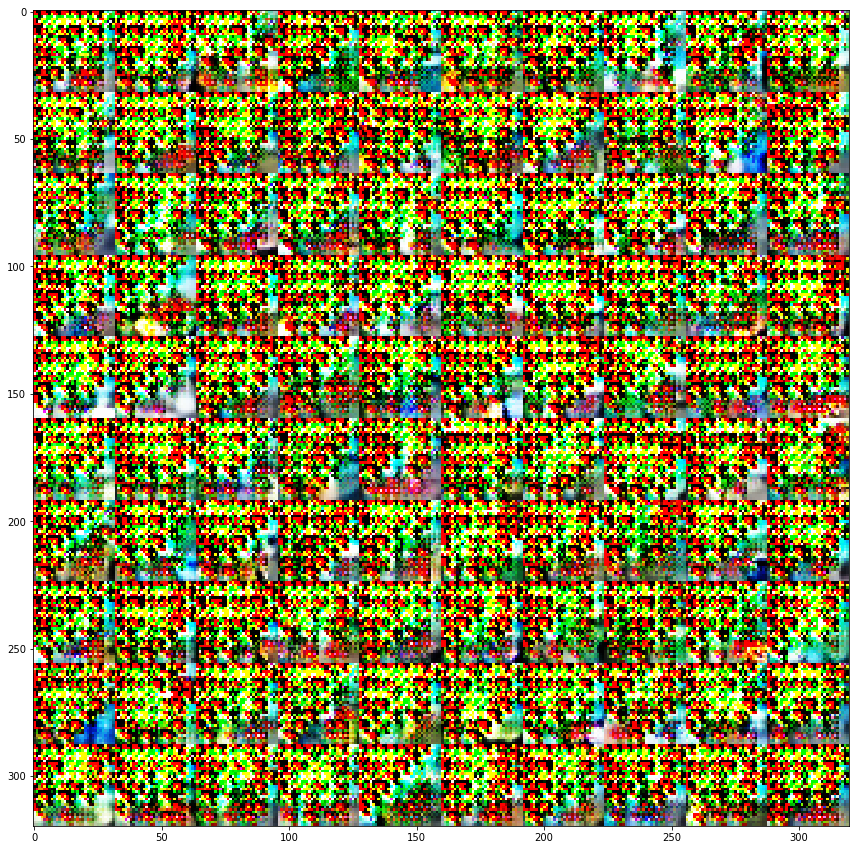

In [15]:
import matplotlib.pyplot as plt
n = 10
figure = np.zeros((img_rows * n, img_cols * n, img_chns))

batches = (n * n + batch_size - 1) // batch_size
digits = []
for i in range(batches):
    z_sample = np.random.normal(size=[batch_size, latent_dim]).reshape(batch_size, latent_dim)
    x_decoded, x_decoded_s = decoder.predict(z_sample, batch_size=batch_size)
    digits += [x_decoded[i].reshape(img_rows, img_cols, img_chns) for i in range(batch_size)]

for j in range(n):
    for i in range(n):
        digit = digits[j * n + i]
        d_x = i * img_rows
        d_y = j * img_cols
        figure[d_x:d_x + img_rows, d_y:d_y + img_cols] = digit
        
plt.figure(figsize=(15, 15))
plt.imshow(figure)
plt.show()